<a href="https://colab.research.google.com/github/Jnghne/LSTM-Based-Autoencoder/blob/main/LSTM_AE_ESCAL_50khz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



> LSTM AE 샘플 코드에 승강기 데이터 적용 (데이터 형태 맞춤)


In [ ]:
# import libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras import regularizers

In [ ]:
# 결과를 디버깅하거나 결과를 똑같이 재현하기 위해 tf 변수에 random seed를 사용한다
seed(10)
tf.random.set_seed(10)

## 데이터 불러오기


In [ ]:
# 정상 데이터 불러오기 
train_data_pd = pd.read_csv("drive/MyDrive/Colab Notebooks/data/high/normal.csv",skiprows=[0,1,2,3,4,5,6,7,8],nrows=30000000,names=["time","data","NaN"])
# 이상 데이터 불러오기 
test_data_pd = pd.read_csv("drive/MyDrive/Colab Notebooks/data/high/abnormal_11.csv", skiprows=3000009,nrows=30000000, names=["time","data","NaN"])  

#pd.DataFrame -> list
train_data_list = train_data_pd['data'].values.tolist()
test_data_list = test_data_pd['data'].values.tolist()

[-0.0016556846, 0.0058059339, 0.0024062616, -0.0018322909]


30015488
30015488


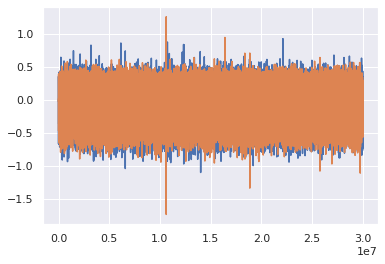

In [ ]:
# raw 데이터 시각화
plt.plot(train_data_list)
plt.plot(test_data_list)
plt.show()

## 데이터 전처리 (1) : 데이터 형태 변형 후 분할

*   데이터 형태 : 
   1. 20khz 10분짜리 데이터를 5초 간격으로 묶음
   2. 5초 간격으로 묶은 데이터 10만개를 하나의 ***양의 평균값***으로 도출
  




In [ ]:
## <데이터 변형>
# 1. 소음 데이터 절대값 씌우기  
# 2. 10만개씩 끊어서 배열로 만들기 (5초 단위로 포인트 생성 위함)
# 3. 5초 간격 데이터의 평균값 도출

train_data_all = np.array(list(map(abs, train_data_list))) 
train_data_all = train_data_all.reshape(-1,100000)
train_data_all = np.mean(train_data_all,axis=1).reshape(-1,1)

train_data=train_data_all[0:-10]
validation_data=train_data_all[-11:-1]

test_data = np.array(list(map(abs, test_data_list))) 
test_data = test_data.reshape(-1,100000)
test_data = np.mean(test_data,axis=1).reshape(-1,1)

print("Training dataset shape:", train_data.shape)
print("Test dataset shape:", test_data.shape)
print("Validation dataset shape:", validation_data.shape)

Training dataset shape: (290, 1)
Test dataset shape: (300, 1)
Validation dataset shape: (10, 1)


## 데이터 시각화




*   데이터의 진폭 값 시각화




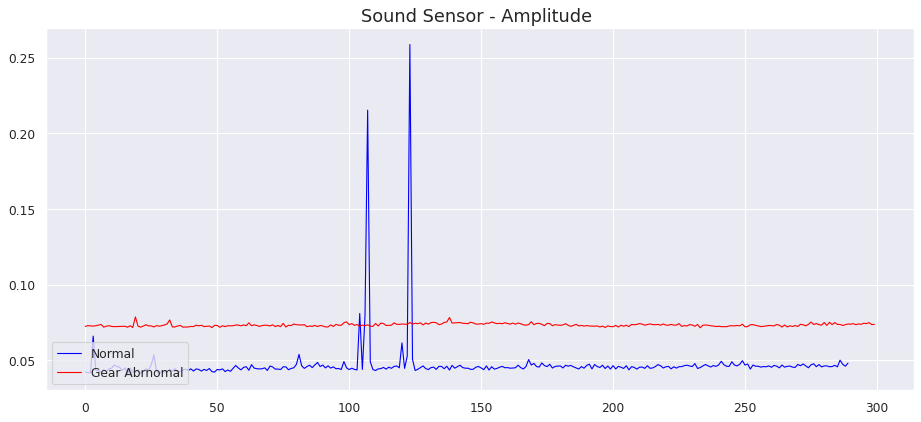

In [ ]:
# 훈련 데이터(진동 값) 시각화
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train_data, label='Normal', color='blue', animated = True, linewidth=1)
ax.plot(test_data, label='Gear Abrnomal', color='red', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Sound Sensor - Amplitude ', fontsize=16)
plt.show()

*   주파수 영역 시각화



In [ ]:
# FFT를 사용해 데이터를 시간 영역에서 주파수 영역으로 변환
train_fft = np.fft.fft(train_data) / len(train_data)
test_fft = np.fft.fft(test_data) / len(test_data)

# 훈련 데이터(고장 발생 전)의 주파수 영역 시각화
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train_fft, label='Normal', color='blue', animated = True, linewidth=1)
ax.plot(test_fft, label='Abnormal', color='red', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Sound Sensor - Frequency ', fontsize=16)
plt.show()

*   스펙트로그램 시각화



ValueError: ignored

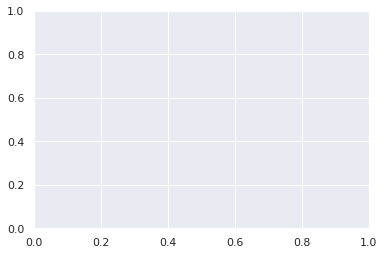

In [ ]:
# 데이터 스펙트로그램으로 시각화
plt.figure(1)
plt.specgram(train_data, Fs=20000)
plt.show()
plt.close(1)

plt.figure(2)
plt.specgram(test_data, Fs=20000)
plt.show()
plt.close(2)

## 데이터 전처리 (2) : 정규화

In [ ]:
# 데이터 정규화 (0~1사이로 데이터를 정규화)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train_data)
X_test = scaler.transform(test_data)
X_validation = scaler.transform(validation_data)
# scaler_filename = "scaler_data"
# joblib.dump(scaler, scaler_filename)


*   LSTM 레이어의 입력 형태로 데이터 변형




In [ ]:
# LSTM 네트워크에 입력하기 위해 데이터 형태를 변형한다 -> [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)
X_validation = X_validation.reshape(X_validation.shape[0], 1, X_validation.shape[1])
print("Validation data shape:", X_validation.shape)

Training data shape: (290, 1, 1)
Test data shape: (300, 1, 1)
Validation data shape: (10, 1, 1)


## 신경망 구축

In [ ]:
# 오토인코더 신경망 구축 (신경망을 LSTM 레이어로 구축)
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    # return_sequences 가 True면 각 time_steps의 셀이 모두 출력으로 내보냄 , False 면 최종 셀만 출력으로 내보냄
    L1 = LSTM(24, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(10, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(10, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(24, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [ ]:
# 오토인코더 모델 생성
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1)]            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 24)             2496      
_________________________________________________________________
lstm_5 (LSTM)                (None, 10)                1400      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 10)             0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 1, 10)             840       
_________________________________________________________________
lstm_7 (LSTM)                (None, 1, 24)             3360      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 1)              25  

## 모델 학습

In [ ]:
# 모델 학습 및 평가
nb_epochs = 100
batch_size = 10
callbacks = [EarlyStopping(monitor='val_loss', patience=5)]
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,callbacks=callbacks, validation_split=0.04348).history

Epoch 1/100
28/28 [==============================] - 0s 7ms/step - loss: 0.0200 - val_loss: 0.0087
Epoch 2/100
28/28 [==============================] - 0s 5ms/step - loss: 0.0144 - val_loss: 0.0077
Epoch 3/100
28/28 [==============================] - 0s 4ms/step - loss: 0.0139 - val_loss: 0.0046
Epoch 4/100
28/28 [==============================] - 0s 5ms/step - loss: 0.0136 - val_loss: 0.0063
Epoch 5/100
28/28 [==============================] - 0s 6ms/step - loss: 0.0129 - val_loss: 0.0038
Epoch 6/100
28/28 [==============================] - 1s 32ms/step - loss: 0.0105 - val_loss: 0.0039
Epoch 7/100
28/28 [==============================] - 0s 5ms/step - loss: 0.0102 - val_loss: 0.0083
Epoch 8/100
28/28 [==============================] - 0s 5ms/step - loss: 0.0088 - val_loss: 0.0070
Epoch 9/100
28/28 [==============================] - 0s 5ms/step - loss: 0.0083 - val_loss: 0.0073
Epoch 10/100
28/28 [==============================] - 0s 5ms/step - loss: 0.0088 - val_loss: 0.0056




*   학습 결과 시각화(loss)



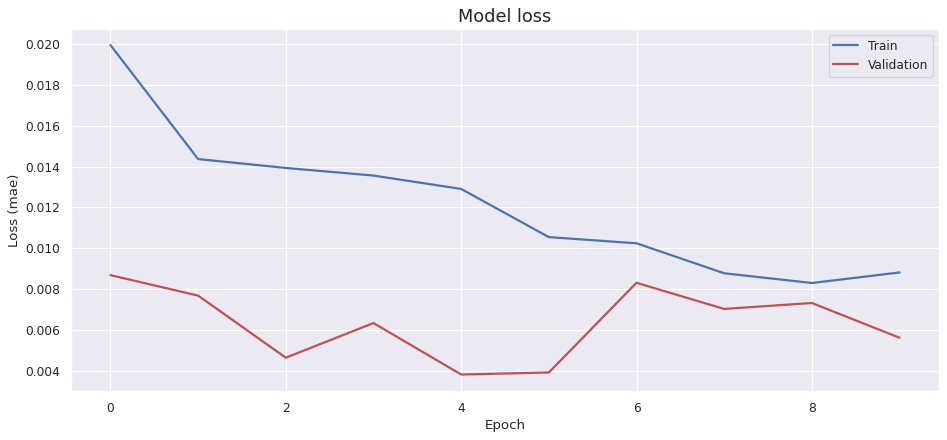

In [ ]:
# 학습 손실 시각화
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

*   훈련 데이터로 **재구성 손실값** 도출


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


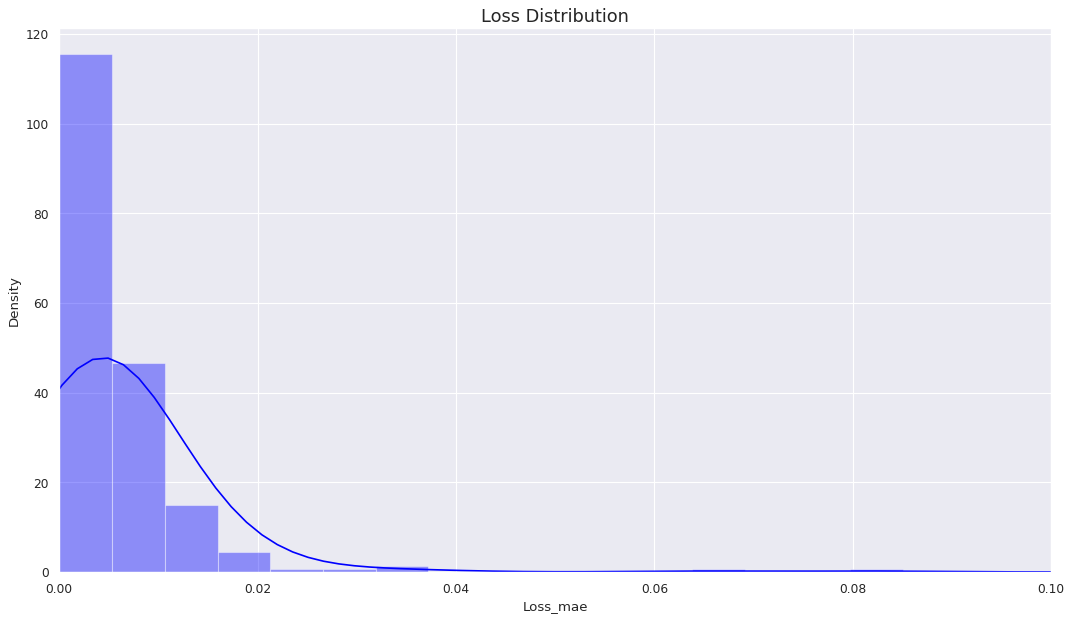

In [ ]:
### 모델에 훈련 데이터 넣어서 재구성 손실값 도출

# 모델 예측값
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2]) 
X_pred = pd.DataFrame(X_pred)

# 원본 데이터 값 
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2]) 

# 재구성 손실값 도출
scored = pd.DataFrame()
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1) 

# 시각화
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
plt.xlim([0,0.1])
sns.distplot(scored['Loss_mae'], kde= True, color = 'blue');

# 임계값 설정
Threshold = 0.04

## 테스트

*   고장 데이터



In [ ]:
# 이상 데이터로 재구성 손실값 계산
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred)

# 이상 데이터 손실값으로 임계값 넘었는지 확인
scored = pd.DataFrame()
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = Threshold
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
print(scored)

     Loss_mae  Threshold  Anomaly
0    0.106327       0.04     True
1    0.108278       0.04     True
2    0.107786       0.04     True
3    0.107053       0.04     True
4    0.108035       0.04     True
..        ...        ...      ...
295  0.114212       0.04     True
296  0.113168       0.04     True
297  0.115776       0.04     True
298  0.110890       0.04     True
299  0.111279       0.04     True

[300 rows x 3 columns]


*   학습에 사용되지 않은 정상 데이터(검증 데이터)


In [ ]:
# 정상 데이터(학습 시 사용 X) 재구성 손실 값 
X_pred_val = model.predict(X_validation)
X_pred_val = X_pred_val.reshape(X_pred_val.shape[0], X_pred_val.shape[2])
X_pred_val = pd.DataFrame(X_pred_val)

# 검증 데이터 손실값으로 임계값 넘었는지 확인
scored_val = pd.DataFrame()
Xvalidation = X_validation.reshape(X_validation.shape[0], X_validation.shape[2])
scored_val['Loss_mae'] = np.mean(np.abs(X_pred_val-Xvalidation), axis = 1)
scored_val['Threshold'] = Threshold
scored_val['Anomaly'] = scored_val['Loss_mae'] > scored_val['Threshold']
print(scored_val)

   Loss_mae  Threshold  Anomaly
0  0.011382       0.04    False
1  0.001455       0.04    False
2  0.008688       0.04    False
3  0.007068       0.04    False
4  0.007916       0.04    False
5  0.010317       0.04    False
6  0.000447       0.04    False
7  0.004836       0.04    False
8  0.020726       0.04    False
9  0.032001       0.04    False
